### DDPM : Air Quality Dataset

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from scipy import stats
from IPython.display import display, clear_output
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [77]:
import pandas as pd
import numpy as np

# Load data with Date and Time columns
data = pd.read_csv('Air.csv')
features = data.drop(columns=['Date', 'Time'])

Code after taking diagnal element of the cov matrix

In [78]:
# The diffusion kernel returns the parameters of Pr(z_{t}|x)
def diffusion_kernel(x, t, beta,sigma_t):             # (current data points, current diffusion step, a noise parameter)
    alpha = np.power(1-beta,t)
    dk_mean = x * np.sqrt(alpha)                       # Mean of Diffusion Kernel
    dk_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return dk_mean, dk_std

# Beta  = Noise
# Alpha = Parameter which tell us about how much information to keep.   (alpha = 1 - Beta)

def conditional_diffusion_distribution(x, z_t, t, beta,sigma_t):    # Z_t  = Predicted value at current data point, t = current diffusion step,  beta = the noise parameter
    # Compute diffusion kernel parameters
    dk_mean, dk_std = diffusion_kernel(x, t, beta, sigma_t)
    
    # Compute conditional diffusion distribution parameters
    alpha = np.power(1 - beta, t)
    cd_mean = z_t / np.sqrt(alpha)  # Adjust the coefficient as needed          cd_mean = predicted mean at current step.
    cd_std = np.sqrt(beta * sigma_t)  # Extract standard deviations from diagonal of sigma_t
    return cd_mean, cd_std

def get_data_pairs(x_train, t, beta, sigma_t):


  # Extract diagonal elements (standard deviations) from sigma_t
  #sigma_t_diag = np.diag(sigma_t)  # Assuming sigma_t is a covariance matrix

  # Reshape sigma_t_diag for element-wise multiplication
  #sigma_t_reshaped = np.tile(sigma_t_diag, (x_train.shape[0], 1))

  # Find diffusion kernel for every x_train and draw samples (element-wise multiplication)
  dk_mean, dk_std = diffusion_kernel(x_train, t, beta, sigma_t)
  print(x_train.shape)
  z_t = dk_std * np.random.normal(size=x_train.shape) + dk_mean

  # Find conditional diffusion distribution for each x_train, z pair and draw samples
  cd_mean, cd_std = conditional_diffusion_distribution(x_train, z_t, t, beta, sigma_t)

  if t == 1:
    z_tminus1 = x_train  # If first timestep, use the training data directly
  else:
    # Sample z_tminus1 using cd_std and cd_mean (element-wise multiplication)
    z_tminus1 = cd_std * np.random.normal(size=x_train.shape) + cd_mean

  return z_t, z_tminus1



In [79]:
class NonParametricModel():
    # Constructor initializes parameters
    def __init__(self):
        self.inc = 0.01
        self.max_val = 3.0
        self.model = []

    # Learns a model that predicts z_t_minus1 given z_t
    def train(self, zt, zt_minus1):
        zt = np.clip(zt, -self.max_val, self.max_val)
        zt_minus1 = np.clip(zt_minus1, -self.max_val, self.max_val)
        bins = np.arange(-self.max_val, self.max_val + self.inc, self.inc)
        numerator, _ = np.histogram(zt, bins=bins, weights=zt_minus1 - zt)
        denominator, _ = np.histogram(zt, bins=bins)
        self.model = numerator / (denominator + 1)

    def predict(self, zt):
        bin_index = np.floor((zt + self.max_val) / self.inc).astype('int')
        bin_index = np.clip(bin_index, 0, len(self.model) - 1)
        return zt + self.model[bin_index]


### Performing Scaling

In [80]:
from sklearn.preprocessing import MinMaxScaler

# Create StandardScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the feature dataset
scaled_df = scaler.fit_transform(features)

# Convert scaled features back to DataFrame (if needed)
scaled_data = pd.DataFrame(scaled_df, columns=features.columns)

Creating Sequence out of dataframe.

In [81]:
# Extract dimensions
seq_len = 24  # Sequence length
num_features = scaled_data.shape[1]  # Number of columns after dropping
num_samples = len(scaled_data) - seq_len + 1  # Number of samples

# Initialize a numpy array to store the 3D array
data_3d = np.zeros((num_samples, seq_len, num_features))

# Populate the 3D array
for i in range(num_samples):
    data_3d[i] = scaled_data.values[i:i+seq_len]

print(data_3d.shape)

(9334, 24, 13)


In [82]:
num_samples, num_time_steps, num_features = data_3d.shape
data_2d = data_3d.reshape(num_samples, num_time_steps * num_features)

print(data_2d.shape)

(9334, 312)


In [83]:
import numpy as np

# Assuming data_2d is your NumPy array

# Calculate the covariance matrix
cov_matrix = np.cov(data_2d, rowvar=False)

print(cov_matrix)

[[ 5.38017769e-01  8.89362199e-03  1.90199475e-02 ... -2.76448985e-02
  -2.16036305e-02 -2.34456734e-02]
 [ 8.89362199e-03  8.68865533e-02  1.01072955e-02 ...  3.65873049e-02
   3.70104181e-02  4.00898309e-02]
 [ 1.90199475e-02  1.01072955e-02  4.06049843e-02 ... -5.80808186e-04
   2.61437606e-04  3.15855709e-04]
 ...
 [-2.76448985e-02  3.65873049e-02 -5.80808186e-04 ...  1.25099340e-01
   1.11311130e-01  1.33910695e-01]
 [-2.16036305e-02  3.70104181e-02  2.61437606e-04 ...  1.11311130e-01
   1.26132377e-01  1.29396088e-01]
 [-2.34456734e-02  4.00898309e-02  3.15855709e-04 ...  1.33910695e-01
   1.29396088e-01  1.48936831e-01]]


In [84]:
# Extract the standard deviations from the diagonal of the covariance matrix
std_devs = np.sqrt(np.diag(cov_matrix))
std_devs

array([0.73349695, 0.29476525, 0.20150678, 0.31421462, 0.28380204,
       0.30683547, 0.22354581, 0.47043723, 0.31430137, 0.33572984,
       0.35366746, 0.355189  , 0.38592364, 0.73349633, 0.29475217,
       0.20145507, 0.31421382, 0.28379968, 0.30683568, 0.22353856,
       0.47044106, 0.31431323, 0.33573815, 0.35367121, 0.35519448,
       0.38592357, 0.73349605, 0.29474494, 0.20141549, 0.31421344,
       0.28379999, 0.30683596, 0.22352268, 0.47045426, 0.31433041,
       0.33575006, 0.3536748 , 0.35520033, 0.3859235 , 0.73349558,
       0.29472702, 0.20138274, 0.31421302, 0.28380272, 0.30683573,
       0.22350931, 0.47045936, 0.31434137, 0.33576151, 0.35367647,
       0.35520109, 0.38592347, 0.73349582, 0.29471726, 0.20135213,
       0.31421333, 0.28380432, 0.30684549, 0.22350357, 0.4704766 ,
       0.31433934, 0.33576021, 0.3536775 , 0.35519834, 0.38592347,
       0.73349625, 0.29471253, 0.20132869, 0.31421347, 0.28380388,
       0.30685376, 0.22348709, 0.47049734, 0.31434143, 0.33577

In [85]:
sigma_t = std_devs

In [86]:
x_train = data_2d

# Define model parameters
T = 800    # Diffusion Steps
beta = 0.01511
#std_random_number = 1    # Old Covariance matrix
all_models = []
sigma_t_reshaped = np.tile(sigma_t, (x_train.shape[0], 1))

for t in range(0, T):
    clear_output(wait=True)

    
    display("Training timestep %d" % (t))
    zt, zt_minus1 = get_data_pairs(x_train, t + 1, beta, sigma_t_reshaped)
    all_models.append(NonParametricModel())
    # The model at index t maps data from z_{t+1} to z_{t}
    all_models[t].train(zt, zt_minus1)


'Training timestep 799'

(9334, 312)


In [87]:
def sample(model, T, sigma_t, n_samples):                           
    samples = np.zeros((T + 1, n_samples, 312))  # Modify shape to include two features                       
    
    # Initialize the samples z_{T} at samples[T,:] from standard normal distribution
    samples[T, :, :] = np.random.normal(size=(n_samples, 312))  # Generate samples for both features

    # For t = 100...99..98... ...0
    for t in range(T, 0, -1):
        clear_output(wait=True)
        display("Predicting z_{%d} from z_{%d}" % (t - 1, t))
        # Predict samples[t-1,:] from samples[t,:] using the appropriate model
        model_t_minus_1 = model[t - 1]
        samples[t - 1, :, :] = model_t_minus_1.predict(samples[t, :])

        # If not the last time step
        if t > 0:
            # Add noise to the samples at z_t-1 we just generated with mean zero, standard deviation sigma_t
            noise = np.random.normal(0, sigma_t[t - 1], size=(n_samples, 312))  # Generate noise for both features
            samples[t - 1, :, :] += noise

    return samples  # Return the samples array containing the generated data for each diffusion step


'Predicting z_{0} from z_{1}'

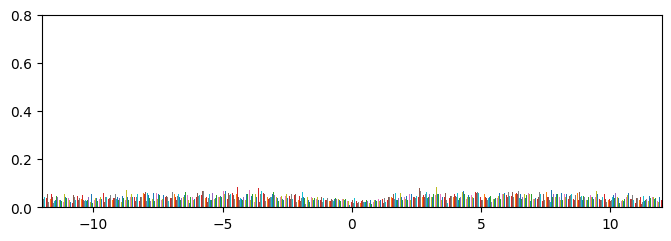

In [88]:
# Assuming T is the number of diffusion steps
T = 800

# Define your sigma_t as a list of standard deviations for each diffusion step
sigma_t

# Repeat the standard deviations to cover all diffusion steps
sigma_t = np.tile(sigma_t, (T // len(sigma_t)) + 1)[:T]

# Convert sigma_t to a numpy array for compatibility with the sample function
sigma_t = np.array(sigma_t)

n_samples = 9334       # Specifies the number of samples to generate using the model.
samples = sample(all_models, T, sigma_t, n_samples) # Call the samples function to generate the new samples


# Plot the data
sampled_data = samples[0,:]
bins = np.arange(-12,12.05,0.05)   # This line defines the bins for the histogram plot, ranging from -3 to 3 with a step size of 0.05.

fig,ax = plt.subplots()
fig.set_size_inches(8,2.5)
ax.set_xlim([-12,12])
plt.hist(sampled_data, bins=bins, density =True)   # This line plots the histogram of the sampled data using the defined bins. The density=True argument normalizes the histogram to form a probability density.
ax.set_ylim(0, 0.8)    # This line sets the y-axis limits.
plt.show()


In [89]:
synthetic_data = pd.DataFrame(sampled_data)
df_actual = data_2d

In [90]:
df_actual.shape

(9334, 312)

In [91]:
synthetic_data.shape

(9334, 312)

In [92]:
synthetic_data.head()

,0,1,2,3,4,5,6,7,8,9,...,302,303,304,305,306,307,308,309,310,311
0,14.053079,15.691091,-6.775758,1.124890,4.074450,-4.597616,-4.959904,-9.111685,8.787350,6.754397,...,-6.827054,-2.741109,4.062300,-8.190209,2.420828,-5.416522,-9.280407,9.934860,2.763709,17.794275
1,-5.062619,15.020270,-1.235496,-0.836873,2.589413,6.692255,31.621406,-16.721535,-4.260839,6.436418,...,7.165527,-15.774902,2.997122,2.298241,-5.700903,-13.671945,-34.886093,3.713495,12.693089,-8.331588
2,-0.399313,-6.271010,-9.902058,4.787308,-17.492437,-11.146915,28.188378,14.064585,-17.893928,-14.567233,...,-3.365714,6.974220,-19.329621,-4.659315,3.988514,-22.575998,9.963246,-6.884232,-0.382656,-4.310819
3,-10.685881,-0.414530,10.788908,3.644129,-25.778535,4.721950,-15.542304,8.867572,1.013366,8.008273,...,1.591557,9.856316,10.006996,-11.828995,15.912408,-9.595342,-19.281193,-17.629375,16.440545,8.059744
4,7.754818,-1.046856,8.443627,4.830266,-15.181383,5.561571,-9.823603,-8.418269,-25.050827,-5.538763,...,12.652856,-10.848578,-3.147649,2.273267,-4.639191,15.334191,18.071923,-3.639884,15.480601,9.132300


In [93]:
from sklearn.preprocessing import StandardScaler

# Create StandardScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the feature dataset
scaled_synthetic = scaler.fit_transform(synthetic_data)

# Convert scaled features back to DataFrame (if needed)
df_synthetic = pd.DataFrame(scaled_synthetic, columns=synthetic_data.columns)

In [94]:
print(df_synthetic.shape)
print(df_actual.shape)

(9334, 312)
(9334, 312)


### PCA Plot

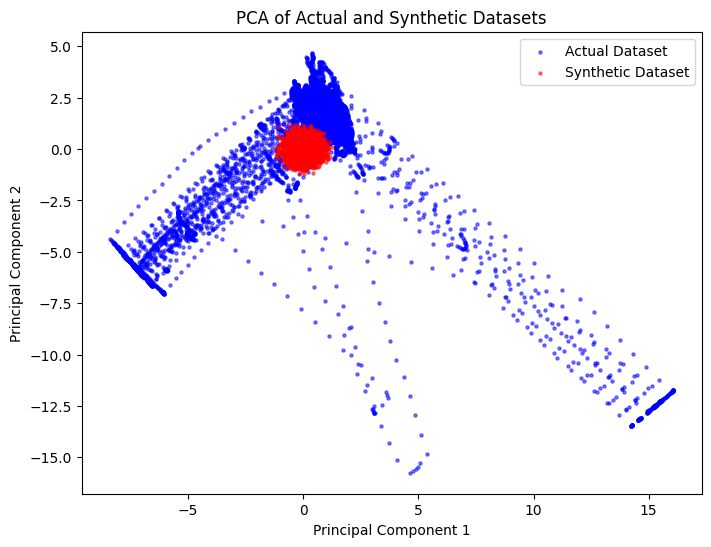

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_actual and df_synthetic are already defined


# Perform PCA on the actual dataset
pca = PCA(n_components=2)
principal_components_1 = pca.fit_transform(df_actual)

# Perform PCA on the synthetic dataset
principal_components_2 = pca.fit_transform(scaled_synthetic)

# Plot both datasets on the same graph with different colors
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_1[:, 0], principal_components_1[:, 1], s=5, alpha=0.5, label='Actual Dataset', color='blue')
plt.scatter(principal_components_2[:, 0], principal_components_2[:, 1], s=5, alpha=0.5, label='Synthetic Dataset', color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Actual and Synthetic Datasets')
plt.legend()
plt.show()

In [96]:
import numpy as np

# Converting 2D array into 3D array
# Reshape to 3D array
actual_data_3d = df_actual.reshape(-1, 24, 13)

print(actual_data_3d.shape)  # Output: (9334, 23, 13)


(9334, 24, 13)


In [97]:
import numpy as np

# Converting 2D array into 3D array
synthetic_data_3d = scaled_synthetic.reshape(-1, 24, 13)

print(synthetic_data_3d.shape)  # Output: (9334, 23, 13)

(9334, 24, 13)


### Distance Metrics

In [98]:
from IPython.display import SVG, display, Image
import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import tsgm

import numpy as np
import functools
import sklearn
import os

statistics = [
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=1),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=1)]

In [99]:
discrepancy_func = lambda x, y: np.linalg.norm(x - y)

In [100]:
dist_metric = tsgm.metrics.DistanceMetric(
    statistics=statistics, discrepancy=discrepancy_func
)
print(dist_metric(actual_data_3d, synthetic_data_3d))

1.2008898127460164e-15


In [101]:
n_samples, sequence_length, n_features = actual_data_3d.shape
reshaped_data = actual_data_3d.reshape((n_samples * sequence_length, n_features))

# Create a DataFrame from the reshaped data
columns = [f"Feature_{i+1}" for i in range(n_features)]
df_actual = pd.DataFrame(reshaped_data, columns=columns)

In [102]:
n_samples, sequence_length, n_features = synthetic_data_3d.shape
reshaped_data1 = synthetic_data_3d.reshape((n_samples * sequence_length, n_features))

# Create a DataFrame from the reshaped data
columns = [f"Feature_{i+1}" for i in range(n_features)]
df_generated = pd.DataFrame(reshaped_data1, columns=columns)

In [103]:
df_actual.columns = features.columns
df_generated.columns = features.columns

In [104]:
df_actual.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.912223,0.392857,-0.496040,0.607129,0.032312,-0.564026,-0.128685,0.159259,0.271933,0.078223,0.746525,0.724281,0.985431
1,0.906560,0.332143,-0.550756,0.588168,-0.043082,-0.639071,-0.046826,0.081481,0.182521,-0.139185,0.744072,0.715968,0.985111
2,0.908447,0.430357,-0.585313,0.585135,-0.056338,-0.605718,-0.070413,0.162963,0.179832,-0.064267,0.732625,0.759612,0.985355
3,0.908447,0.407143,-0.596832,0.586651,-0.048882,-0.556879,-0.103711,0.192593,0.199328,0.030481,0.725266,0.801178,0.985716
4,0.902784,0.314286,-0.638589,0.566174,-0.141674,-0.605718,-0.025321,0.170370,0.136134,-0.037826,0.726901,0.798407,0.985737


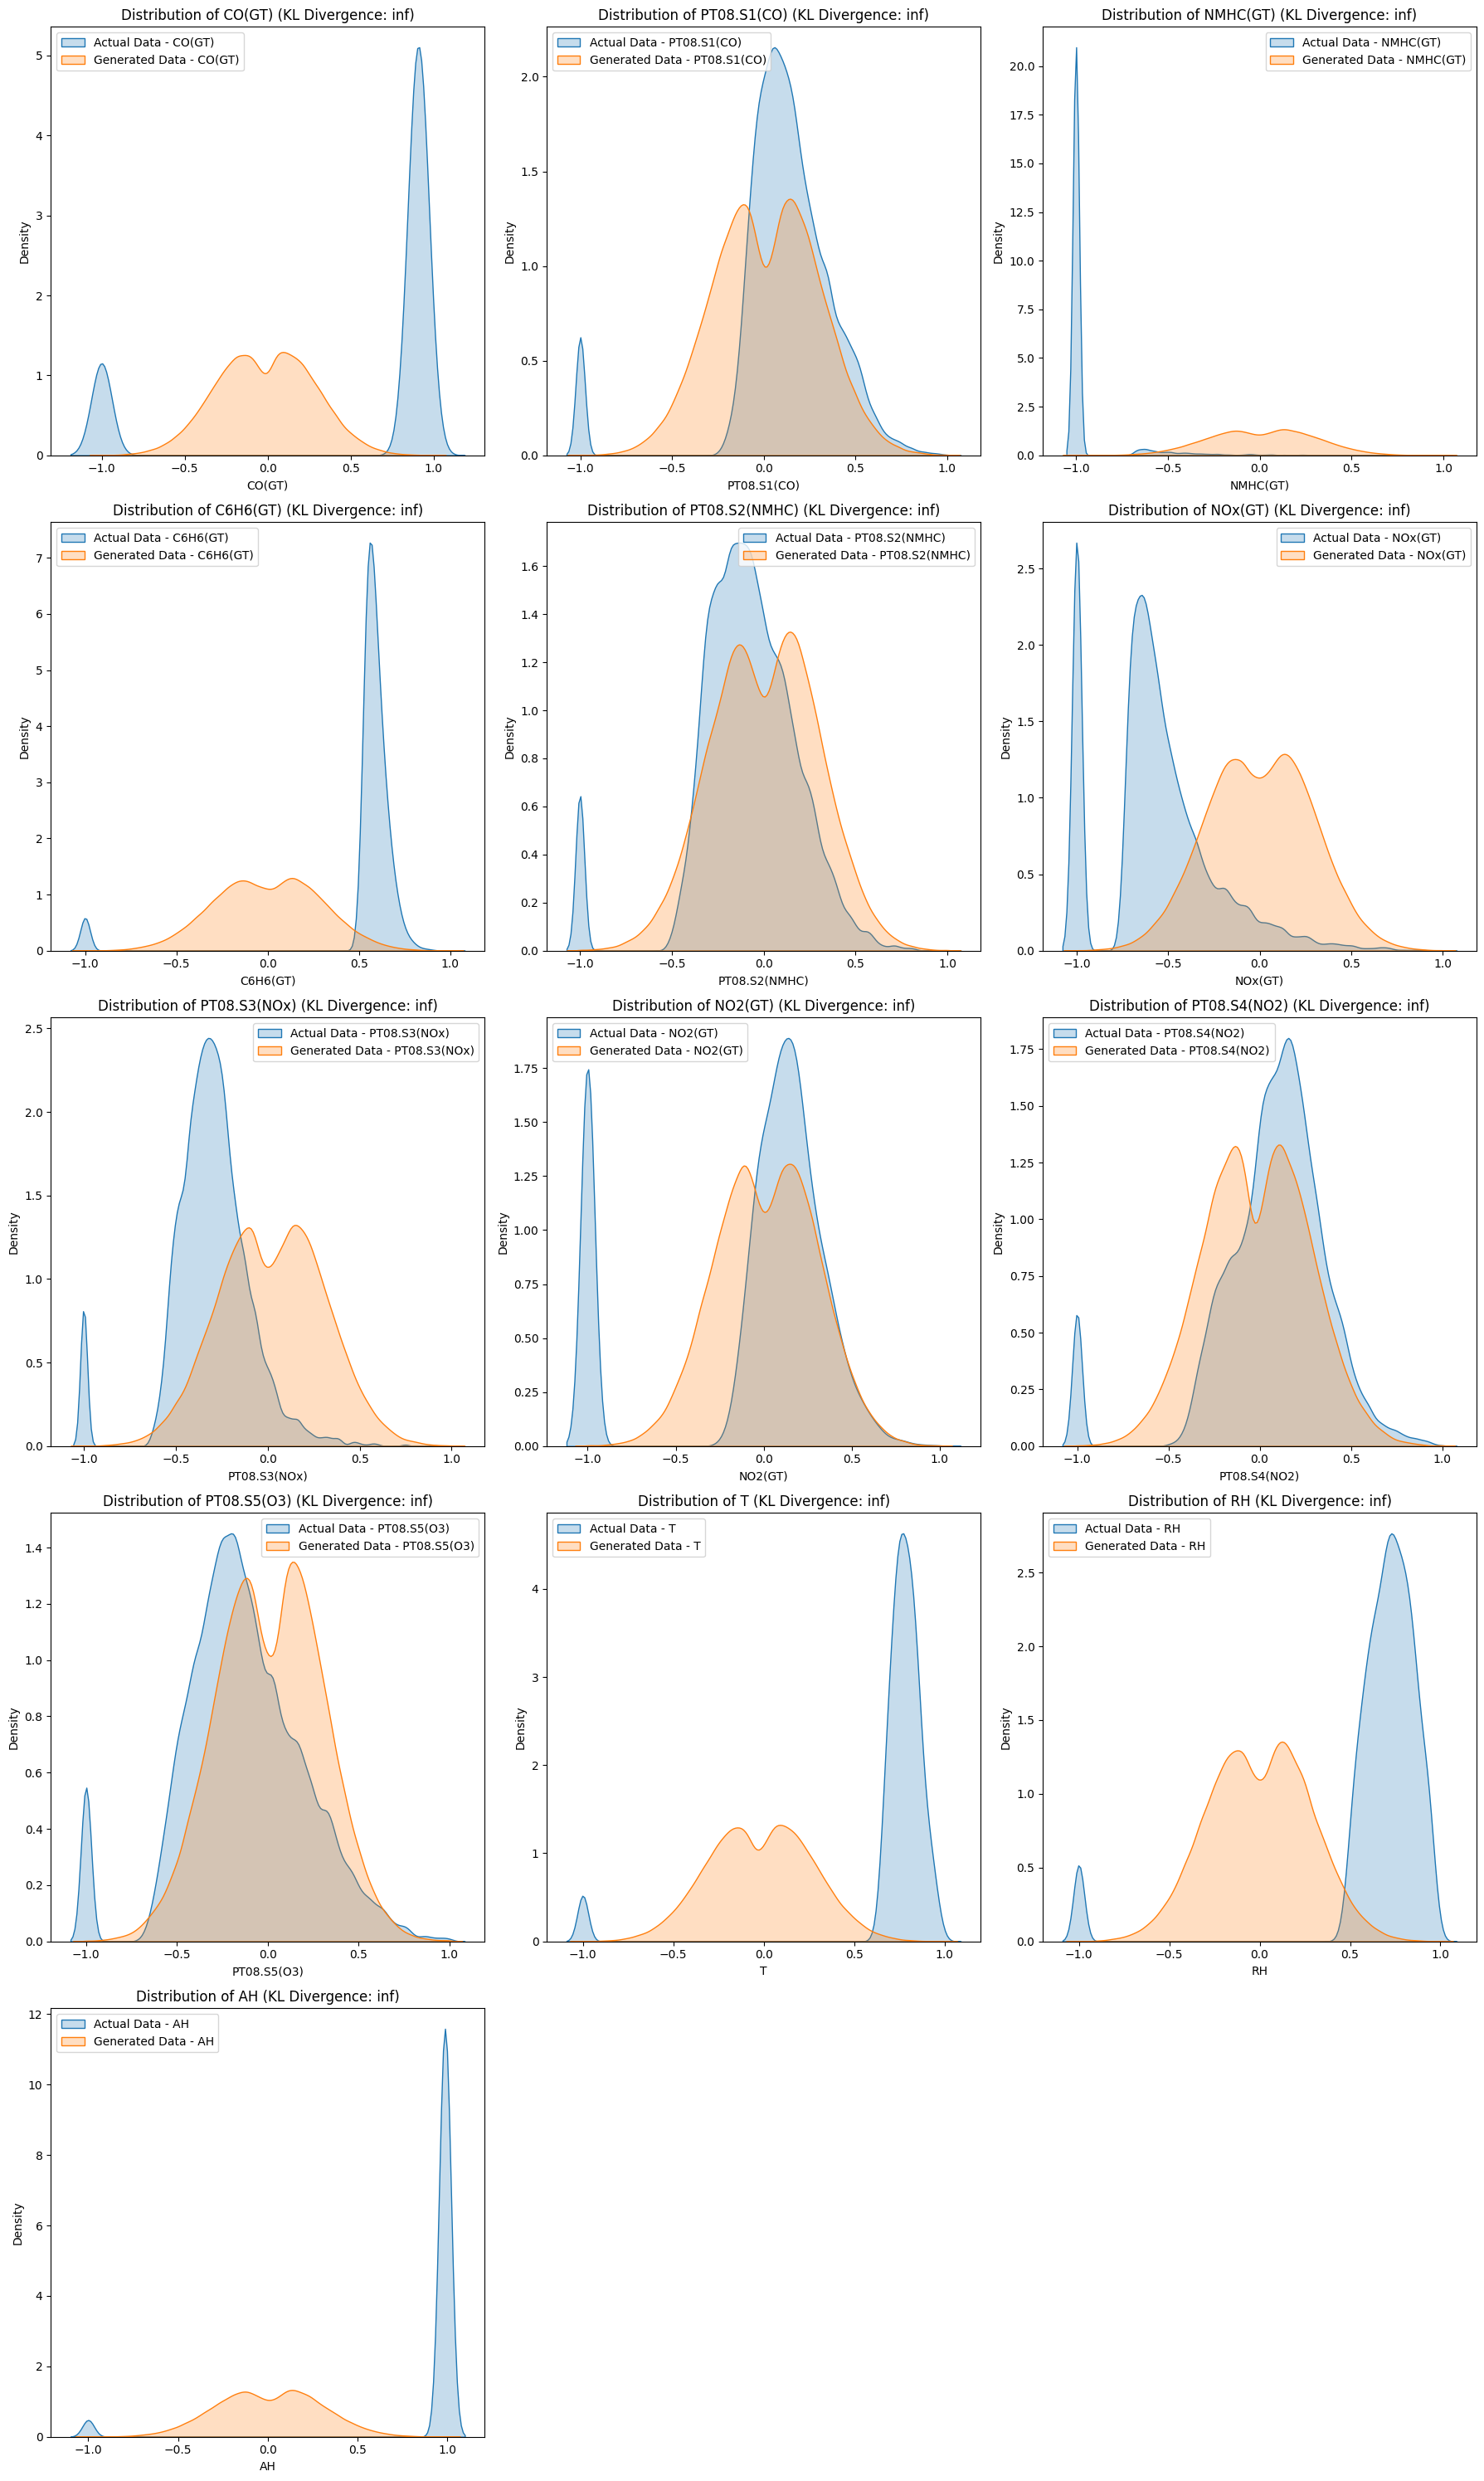

Average KL Divergence: inf


In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

# Assuming df_actual and df_synthetic are your DataFrames

# Initialize a list to store KL Divergence scores
kl_divergences = []

# Number of features
num_features = len(df_actual.columns)

# Calculate the number of rows needed (3 graphs per row)
num_rows = int(np.ceil(num_features / 3))

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and corresponding subplot axis
for i, feature in enumerate(df_actual.columns):
    sns.kdeplot(df_actual[feature], label=f'Actual Data - {feature}', fill=True, ax=axes[i])
    sns.kdeplot(df_generated[feature], label=f'Generated Data - {feature}', fill=True, ax=axes[i])
    
    # Calculate KL Divergence
    kl_divergence = entropy(df_actual[feature], df_generated[feature])
    kl_divergences.append(kl_divergence)
    
    # Add title and legend
    axes[i].set_title(f'Distribution of {feature} (KL Divergence: {kl_divergence:.4f})')
    axes[i].legend()

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Calculate average KL Divergence
average_kl_divergence = sum(kl_divergences) / len(kl_divergences)
print(f'Average KL Divergence: {average_kl_divergence:.4f}')
